In [1]:
"""
This example is from doi:10.1016/j.jcat.2007.05.011, Horn 2007
Ref 17 is doi:10.1016/j.cat.2006.05.008
Ref 18 is doi:10.1007/s10562-006-0117-8

surface to reactor volume ratio (assuming same active catalytic area) A/V, at 1600.0 m-1, from Ref 17
assume catalyst is a monolith, at 16.5 mm in diam, from Ref 17 & Ref 18
porosity is 0.81, from Ref 17
front heat sheild, cataylst, and back heat sheild is 10 mm long, from Ref 17
inlet mol flow at 0.208 mol/min

graphs are in:
exit conversion % v c/0 ratio
flow/mol/min v position(mm)
S at end oxidation zone/ % v C/O ratio
selectivity S, yield(Y)/% v C/O ratio
flow/ mol/min v position (z)/ mm

also had plots with flow/ mol/ min v C/O ratio w lines of thermodynamic equilibrium )ph = const)
"""

# load a bunch of stuff
from __future__ import division
# load
import cantera as ct
import numpy as np
import scipy
import pylab
import matplotlib
import matplotlib.pyplot  as plt
import matplotlib.gridspec as gridspec
from matplotlib.pyplot import cm
from matplotlib.ticker import NullFormatter, MaxNLocator, LogLocator
import csv
from pydas.dassl import DASSL
import os
import rmgpy
import rmg
import re
import operator
import pandas as pd
import pylab
from cycler import cycler
import seaborn as sns
import os
%matplotlib inline

# this chemkin file is from the cti generated by rmg
# i only need to import it once
gas = ct.Solution('./chem_annotated.cti','gas')
surf = ct.Interface('./chem_annotated.cti','surface1', [gas])
# cantera files without gas??
# gas2 = ct.Solution('./chem_annotated.cti','gas')
# gas2.set_multiplier(0.0)
# surf2 = ct.Interface('./chem_annotated.cti','surface1', [gas2])

# gas3 = ct.Solution('./chem_annotated.cti','gas')
# surf3 = ct.Interface('./chem_annotated.cti','surface1', [gas3])

print "This mechanism contains %d gas reactions and %d surface reactions"%(gas.n_reactions, surf.n_reactions)
i_ar = gas.species_index('Ar')
i_ch4 = gas.species_index('CH4(2)')
i_o2 = gas.species_index('O2(3)')
i_co2 = gas.species_index('CO2(4)')
i_h2o = gas.species_index('H2O(5)')
i_h2 = gas.species_index('H2(6)')
i_co = gas.species_index('CO(7)')

errors = []

# unit conversion factors to SI
mm = 0.001
cm = 0.01
ms = mm
minute = 60.0

#######################################################################
# Input Parameters
#######################################################################
t_in = 700 #K - in the paper, it was ~698.15K at the start of the cat surface and ~373.15 for the gas inlet temp
t_cat = t_in 
length = 70 * mm  # Reactor length - catalyst length 10mm, but it doesn't say where.  let's guess at 1 cm?
diam = 16.5*mm # Reactor diameter 
area = (diam/2.0)**2*np.pi  # Reactor cross section area (area of tube) in m^2
porosity = 0.81  # Monolith channel porosity, from Horn ref 17 sec 2.2.2
cat_area_per_vol = 1600.  # Catalyst particle surface area per unit volume in m-1
flow_rate = 4.7 # slpm
flow_rate = flow_rate*.001/60 # m^3/s
velocity = flow_rate/area # m/s

# The PFR will be simulated by a chain of 'NReactors' stirred reactors.
NReactors = 7001

on_catalyst = 1000
off_catalyst = 2000
dt = 1.0

reactor_len = length/(NReactors-1)
rvol = area * reactor_len * porosity

# catalyst area in one reactor
cat_area = cat_area_per_vol * rvol

mass_flow_rate = velocity * gas.density * area # kg/s


Using Theano backend.
/scratch/westgroup/mazeau/Cat/RMG-Py/rmgpy/tools/plot.py:34: UserWarning: 
This call to matplotlib.use() has no effect because the backend has already
been chosen; matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

The backend was *originally* set to 'module://ipykernel.pylab.backend_inline' by the following code:
  File "/home/mazeau.e/anaconda2/envs/rmg_env3/lib/python2.7/runpy.py", line 174, in _run_module_as_main
    "__main__", fname, loader, pkg_name)
  File "/home/mazeau.e/anaconda2/envs/rmg_env3/lib/python2.7/runpy.py", line 72, in _run_code
    exec code in run_globals
  File "/home/mazeau.e/anaconda2/envs/rmg_env3/lib/python2.7/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/home/mazeau.e/anaconda2/envs/rmg_env3/lib/python2.7/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/home/maz

This mechanism contains 42 gas reactions and 19 surface reactions


In [2]:
def monolithFull(gas,surf,temp,mol_in,verbose=False,sens=False):
    """
    Verbose prints out values as you go along
    Sens is for sensitivity, in the form [perturbation, reaction #]
    """
    
    # toto: change n2 to ar
    ch4,o2,ar = mol_in
    ch4=str(ch4);o2=str(o2);ar=str(ar)
    X = str('CH4(2):'+ch4+', O2(3):'+o2+', Ar:'+ar)
    gas.TPX = temp, ct.one_atm, X
    temp_cat = temp
    surf.TP = temp_cat, ct.one_atm
    surf.coverages = 'X(1):1.0'
    gas.set_multiplier(1.0)
    
    TDY = gas.TDY
    cov = surf.coverages

    if verbose is True:
        print('  distance(mm)   X_CH4        X_O2        X_H2       X_CO       X_H2O       X_CO2')

    # create a new reactor
    gas.TDY = TDY
    r = ct.IdealGasReactor(gas)
    r.volume = rvol

    # create a reservoir to represent the reactor immediately upstream. Note
    # that the gas object is set already to the state of the upstream reactor
    upstream = ct.Reservoir(gas, name='upstream')

    # create a reservoir for the reactor to exhaust into. The composition of
    # this reservoir is irrelevant.
    downstream = ct.Reservoir(gas, name='downstream')

    # Add the reacting surface to the reactor. The area is set to the desired
    # catalyst area in the reactor.
    rsurf = ct.ReactorSurface(surf, r, A=cat_area)

    # The mass flow rate into the reactor will be fixed by using a
    # MassFlowController object.
    m = ct.MassFlowController(upstream, r, mdot=mass_flow_rate)

    # We need an outlet to the downstream reservoir. This will determine the
    # pressure in the reactor. The value of K will only affect the transient
    # pressure difference.
    v = ct.PressureController(r, downstream, master=m, K=1e-5)

    sim = ct.ReactorNet([r])
    sim.max_err_test_fails = 12

    # set relative and absolute tolerances on the simulation
    sim.rtol = 1.0e-10
    sim.atol = 1.0e-18

    gas_names = gas.species_names
    surf_names = surf.species_names
    gas_out = [] # in mol fractions
    surf_out = []
    dist_array=[]
    T_array = []


    surf.set_multiplier(0.0) #no surface reactions until the gauze
    for n in range(NReactors):
        # Set the state of the reservoir to match that of the previous reactor
        gas.TDY = r.thermo.TDY
        upstream.syncState()
        if n==on_catalyst:
            surf.set_multiplier(1.0)
            if sens is not False:
                surf.set_multiplier(1.0+sens[0],sens[1])
        if n==off_catalyst:
            surf.set_multiplier(0.0)
        sim.reinitialize()
        sim.advance_to_steady_state()
        dist = n * reactor_len * 1.0e3   # distance in mm
        dist_array.append(dist)
        T_array.append(surf.T)
        gas_out.append(gas.X.copy())
        surf_out.append(surf.X.copy())

        if verbose is True:
            if not n % 100:
                print('  {0:10f}  {1:10f}  {2:10f}  {3:10f} {4:10f} {5:10f} {6:10f}'.format(dist, *gas['CH4(2)','O2(3)','H2(6)','CO(7)','H2O(5)','CO2(4)'].X))
                #print(surf.T)
                #print(gas.P)
                #print(surf.coverages)

    gas_out = np.array(gas_out)
    surf_out = np.array(surf_out)
    gas_names = np.array(gas_names)
    surf_names = np.array(surf_names)
    return gas_out, surf_out, gas_names, surf_names, dist_array, T_array

In [3]:
def plotflow(a):
    gas_out, surf_out, gas_names, surf_names, dist_array, T_array = a
    gas_out = gas_out * .208
    
    # Plot in mol/min
    
    # configure the plot
    fig, axs = plt.subplots(1,2)

    axs[0].set_prop_cycle(cycler('color', ['m', 'g', 'b', 'y', 'c', 'r', 'k','g']))                          

    #PLOT WITH GAS PHASE REACTIONS INCLUDED
    for i in range(len(gas_out[0,:])):
        if i != i_ar:
            if gas_out[:,i].max() > 5.e-3:
    #             print(gas_names[i])
                axs[0].plot(dist_array, gas_out[:,i], label=gas_names[i])
                species_name = gas_names[i]
                if species_name.endswith(')'):
                                if species_name[-3] == '(':
                                    species_name = species_name[0:-3]
                                else:
                                    species_name = species_name[0:-4]
                if species_name == "O2":
                    axs[0].annotate("O$_2$", fontsize=12, xy=(dist_array[3800], gas_out[:,i][3800]+gas_out[:,i][3800]/100.0), va =('bottom'), ha = ('center'))
                elif species_name == "CO2":
                    axs[0].annotate("CO$_2$", fontsize=12, xy=(dist_array[3800], gas_out[:,i][3800]+gas_out[:,i][3800]/10.0), va =('top'), ha = ('center'))
                elif species_name == "CO":
                    axs[0].annotate("CO", fontsize=12, xy=(dist_array[3800], gas_out[:,i][3800]+0.001), va =('bottom'), ha = ('center'))
                elif species_name == "CH2O":
                    axs[0].annotate("CH$_2$O", fontsize=12, xy=(dist_array[3800], gas_out[:,i][3800]+0.001), va =('bottom'), ha = ('center'))    
                elif species_name == "CH4":
                    axs[0].annotate("CH$_4$", fontsize=12, xy=(dist_array[3800], gas_out[:,i][3800]+gas_out[:,i][3800]/100.0), va =('bottom'), ha = ('center'))  
                elif species_name == "H2O":
                    axs[0].annotate("H$_2$O", fontsize=12, xy=(dist_array[3800], gas_out[:,i][3800]+gas_out[:,i][3800]/40.0), va =('top'), ha = ('center'))   
                else:                     
                    axs[0].annotate(species_name, fontsize=12, xy=(dist_array[3800], gas_out[:,i][-1]+gas_out[:,i][-1]/10.0), va =('top'), ha = ('center'))
            else:
                axs[0].plot(0,0)

    axs[1].set_prop_cycle(cycler('color', ['m', 'g', 'b', 'y', 'c', 'r', 'k','g']))  
    axs[1].plot(dist_array, T_array, label="surface + gas reactions")

    axs[0].set_prop_cycle(cycler('color', ['m', 'g', 'b', 'y', 'c', 'r', 'k','g']))   

    axs[0].plot([dist_array[on_catalyst], dist_array[on_catalyst]],[0,0.3], linestyle='--', color='xkcd:grey')
    axs[0].plot([dist_array[off_catalyst], dist_array[off_catalyst]],[0,0.3], linestyle='--', color='xkcd:grey')  
    axs[0].annotate("catalyst", fontsize=13, xy=(dist_array[on_catalyst], 0.275), va =('bottom'), ha = ('left'))
    axs[1].plot([dist_array[on_catalyst], dist_array[on_catalyst]],[400.0,1500], linestyle='--', color='xkcd:grey')
    axs[1].plot([dist_array[off_catalyst], dist_array[off_catalyst]],[400.0,1500], linestyle='--', color='xkcd:grey')
    axs[1].annotate("catalyst", fontsize=13, xy=(dist_array[on_catalyst], 1265), va =('bottom'), ha = ('left'))

    for item in (axs[0].get_xticklabels() + axs[0].get_yticklabels() + axs[1].get_xticklabels() + axs[1].get_yticklabels()):
        item.set_fontsize(12)

    axs[1].legend(loc='upper center', bbox_to_anchor=(0.5, -0.2),fancybox=False, shadow=False, ncol=2)
    axs[0].legend(loc='upper center', bbox_to_anchor=(0.5, -0.2),fancybox=False, shadow=False, ncol=4)
    axs[0].set_ylim(0.,0.1); axs[1].set_ylim(400.0,2400)
    axs[0].set_xlim(0.0,length/mm); axs[1].set_xlim(0.0,length/mm)
    axs[0].set_xlabel('Distance (mm)', fontsize=13); axs[1].set_xlabel('Distance (mm)', fontsize=13); #axs[0,1].set_xlabel('time (s)'); axs[1,1].set_xlabel('time (s)')
    axs[0].set_ylabel('flow/ mol/min', fontsize=13); axs[1].set_ylabel('Temperature (K)', fontsize=13)
    fig.set_figheight(6)
    fig.set_figwidth(18)
    
#     temperature = np.round(T_array[0],0)
    
    for n in range(len(gas_names)):
        if gas_names[n]=='CH4(2)':
            c_in = gas_out[0][n]
        if gas_names[n]=='O2(3)':
            o_in = gas_out[0][n]
    ratio = round(c_in/(o_in*2),1)
    # uncomment to save figure
    fig.savefig(str(ratio)+ 'ratio.png', bbox_inches='tight')

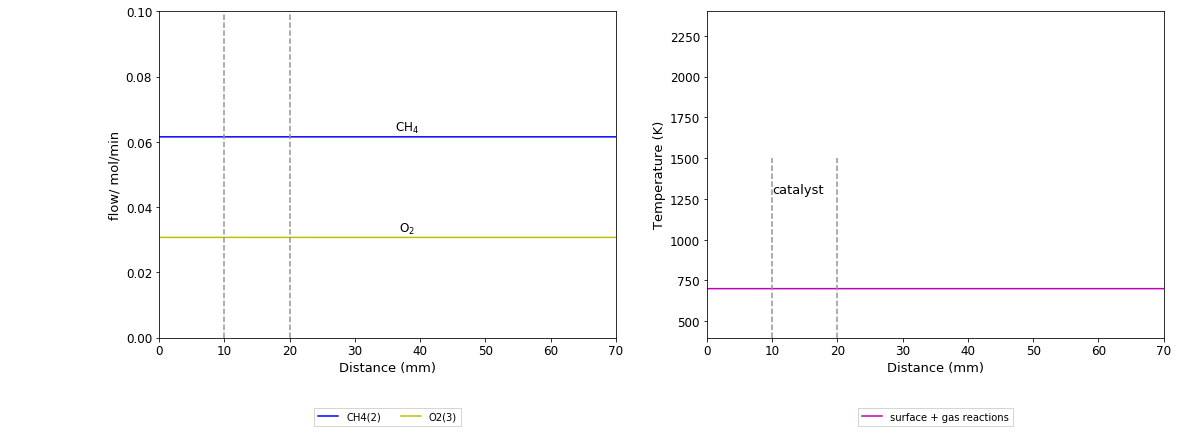

In [4]:
a = monolithFull(gas,surf,t_in,[.061521,.0307,.115718])
plotflow(a)

In [5]:
def plotZoom(a):
    gas_out, surf_out, gas_names, surf_names, dist_array, T_array = a
#     gas2_out, surf2_out, gas2_names, surf2_names, dist2_array, T2_array = b
    # configure the plot
    gas_out = gas_out*0.208
    
    fig, axs = plt.subplots(1,2)

    axs[0].set_prop_cycle(cycler('color', ['m', 'g', 'b', 'y', 'c', 'r', 'k','g']))                          

    #PLOT WITH GAS PHASE REACTIONS INCLUDED
    for i in range(len(gas_out[0,:])):
        if i != i_ar:
            if gas_out[:,i].max() > 5.e-3:
    #             print(gas_names[i])
                axs[0].plot(dist_array, gas_out[:,i], label=gas_names[i])
                species_name = gas_names[i]
                if species_name.endswith(')'):
                                if species_name[-3] == '(':
                                    species_name = species_name[0:-3]
                                else:
                                    species_name = species_name[0:-4]
                if species_name == "O2":
                    axs[0].annotate("O$_2$", fontsize=12, xy=(dist_array[2200], gas_out[:,i][2200]+gas_out[:,i][2200]/100.0), va =('bottom'), ha = ('center'))
                elif species_name == "CO2":
                    axs[0].annotate("CO$_2$", fontsize=12, xy=(dist_array[2200], gas_out[:,i][2200]+gas_out[:,i][2200]/10.0), va =('top'), ha = ('center'))
                elif species_name == "CO":
                    axs[0].annotate("CO", fontsize=12, xy=(dist_array[2200], gas_out[:,i][2200]+0.001), va =('bottom'), ha = ('center'))
                elif species_name == "CH2O":
                    axs[0].annotate("CH$_2$O", fontsize=12, xy=(dist_array[2200], gas_out[:,i][2200]+0.001), va =('bottom'), ha = ('center'))    
                elif species_name == "CH4":
                    axs[0].annotate("CH$_4$", fontsize=12, xy=(dist_array[2200], gas_out[:,i][2200]+gas_out[:,i][2200]/100.0), va =('bottom'), ha = ('center'))  
                elif species_name == "H2O":
                    axs[0].annotate("H$_2$O", fontsize=12, xy=(dist_array[2200], gas_out[:,i][2200]+gas_out[:,i][2200]/40.0), va =('top'), ha = ('center'))   
                else:                     
                    axs[0].annotate(species_name, fontsize=12, xy=(dist_array[-1], gas_out[:,i][-1]+gas_out[:,i][-1]/10.0), va =('top'), ha = ('center'))
            else:
                axs[0].plot(0,0)

    axs[1].set_prop_cycle(cycler('color', ['m', 'g', 'b', 'y', 'c', 'r', 'k','g']))  
    #Plot two temperatures (of gas-phase and surface vs only surface.)
    axs[1].plot(dist_array, T_array, label="surface + gas reactions")
#     axs[1].plot(dist_array, T2_array, "--", label="surface reactions only")


    axs[0].set_prop_cycle(cycler('color', ['m', 'g', 'b', 'y', 'c', 'r', 'k','g']))    

    axs[0].plot([dist_array[on_catalyst], dist_array[on_catalyst]],[0,0.2], linestyle='--', color='xkcd:grey')
    axs[0].plot([dist_array[off_catalyst], dist_array[off_catalyst]],[0,0.2], linestyle='--', color='xkcd:grey')  
    axs[0].annotate("catalyst", fontsize=13, xy=(dist_array[on_catalyst], 0.175), va =('bottom'), ha = ('left'))
    axs[1].plot([dist_array[on_catalyst], dist_array[on_catalyst]],[600.0,2000], linestyle='--', color='xkcd:grey')
    axs[1].plot([dist_array[off_catalyst], dist_array[off_catalyst]],[600.0,2000], linestyle='--', color='xkcd:grey')
    axs[1].annotate("catalyst", fontsize=13, xy=(dist_array[on_catalyst], 1800), va =('bottom'), ha = ('left'))

    for item in (axs[0].get_xticklabels() + axs[0].get_yticklabels() + axs[1].get_xticklabels() + axs[1].get_yticklabels()):
        item.set_fontsize(12)

    axs[1].legend(loc='upper center', bbox_to_anchor=(0.5, -0.2),fancybox=False, shadow=False, ncol=2)
    axs[0].legend(loc='upper center', bbox_to_anchor=(0.5, -0.2),fancybox=False, shadow=False, ncol=4)
    axs[0].set_ylim(0.,0.1); axs[1].set_ylim(600.0,2000)
    axs[0].set_xlim(8,25); axs[1].set_xlim(8,25)
    axs[0].set_xlabel('Distance (mm)', fontsize=13); axs[1].set_xlabel('Distance (mm)', fontsize=13); #axs[0,1].set_xlabel('time (s)'); axs[1,1].set_xlabel('time (s)')
    axs[0].set_ylabel('flow/ mol/min', fontsize=13); axs[1].set_ylabel('Temperature (K)', fontsize=13)
    #fig.tight_layout()
    #axs[1,0].ticklabel_format(axis='x', style='sci', scilimits=(0,0))
    #axs[0,1].ticklabel_format(axis='x', style='sci', scilimits=(0,0))
    #axs[1,1].ticklabel_format(axis='x', style='sci', scilimits=(0,0))
    fig.set_figheight(6)
    fig.set_figwidth(18)

#     temperature = np.round(T_array[0],0)
    for n in range(len(gas_names)):
        if gas_names[n]=='CH4(2)':
            c_in = gas_out[0][n]
        if gas_names[n]=='O2(3)':
            o_in = gas_out[0][n]
    ratio = c_in/(o_in*2)
    ratio = round(ratio,1)
    
    # uncomment to save figure
    fig.savefig(str(ratio)+ 'ratioZoom.png', bbox_inches='tight')

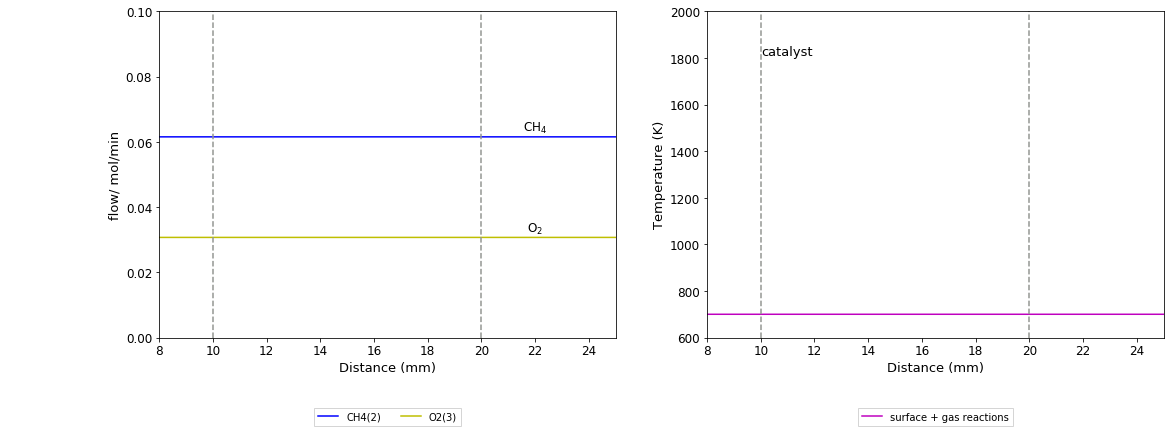

In [6]:
plotZoom(a)

Unable to run simulation at a C/O ratio of 1
Unable to run simulation at a C/O ratio of 1
Unable to run simulation at a C/O ratio of 1
Unable to run simulation at a C/O ratio of 1
Unable to run simulation at a C/O ratio of 1
Unable to run simulation at a C/O ratio of 2
Unable to run simulation at a C/O ratio of 2
Unable to run simulation at a C/O ratio of 3


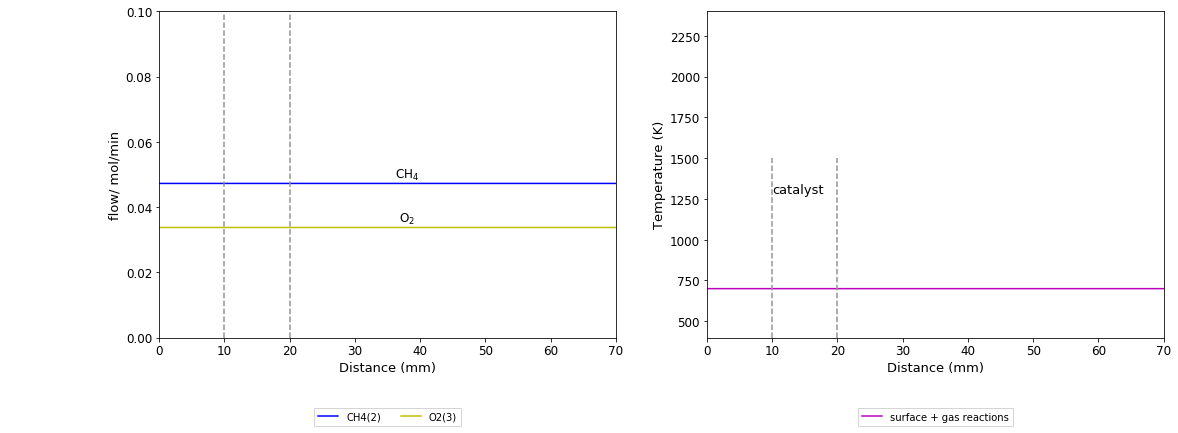

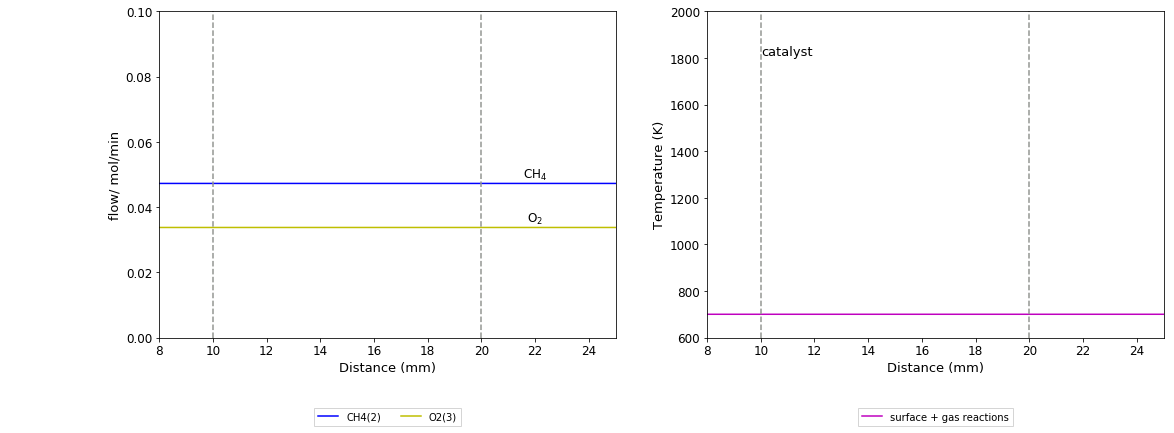

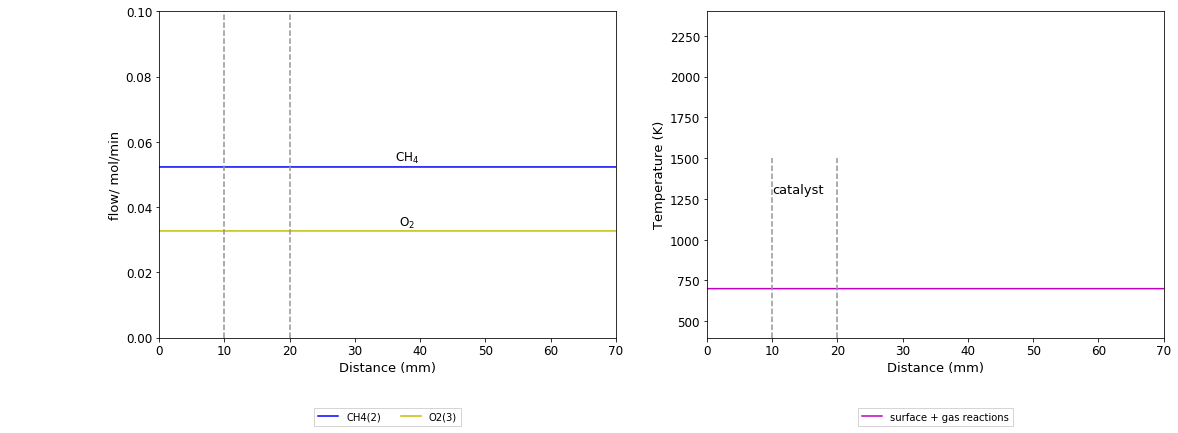

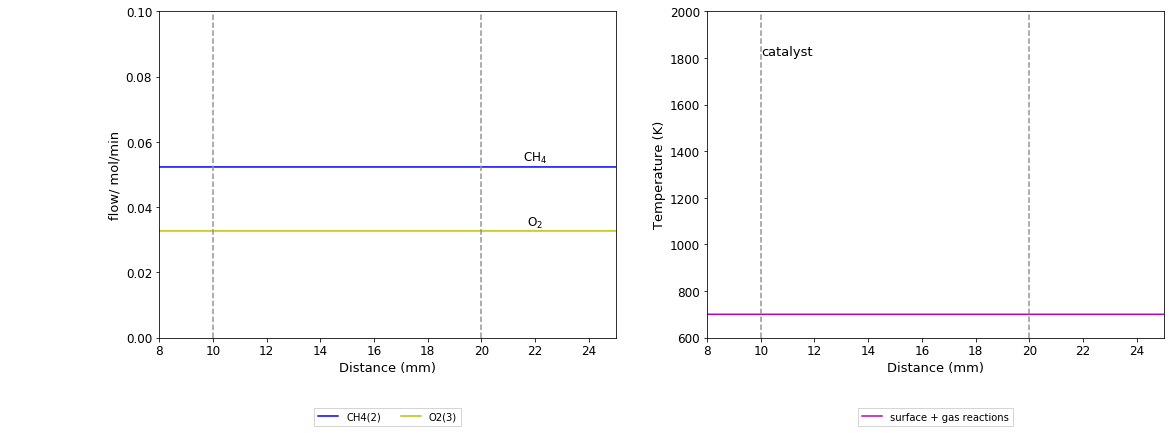

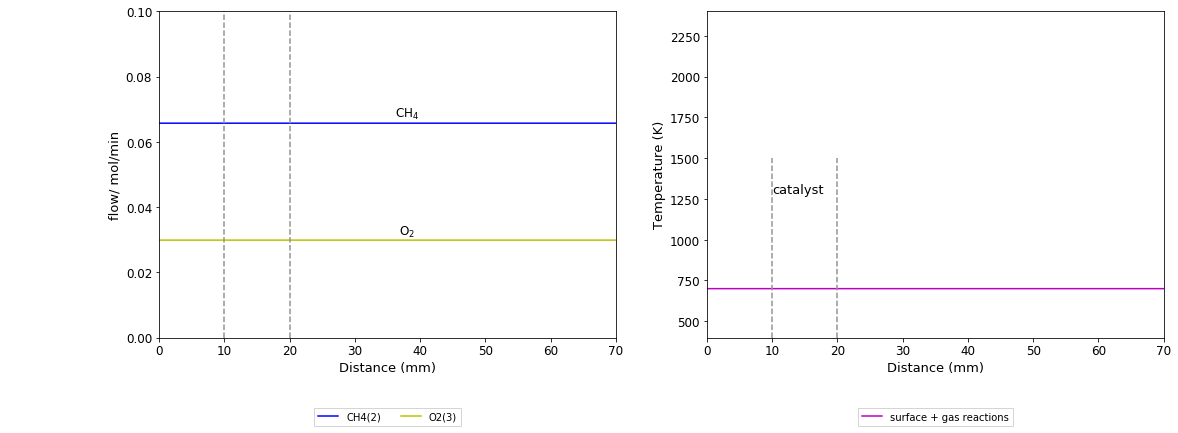

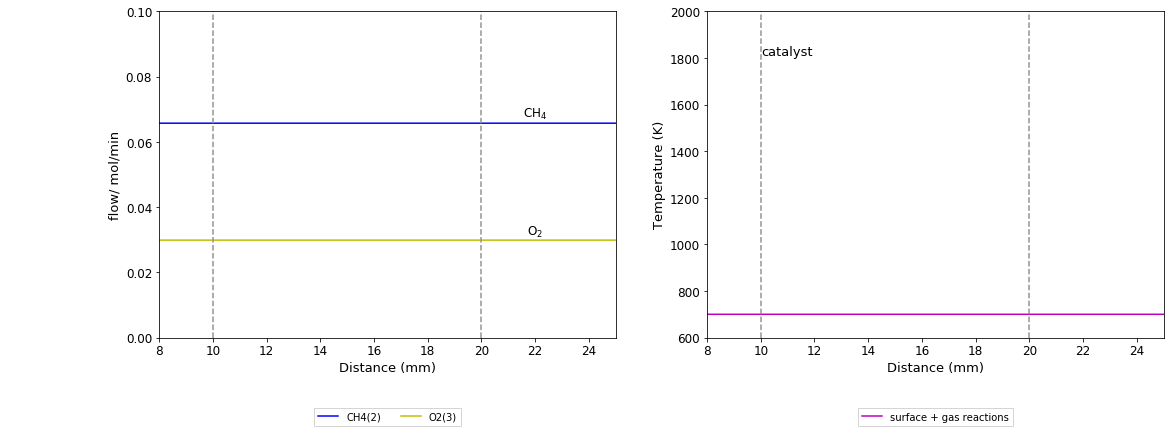

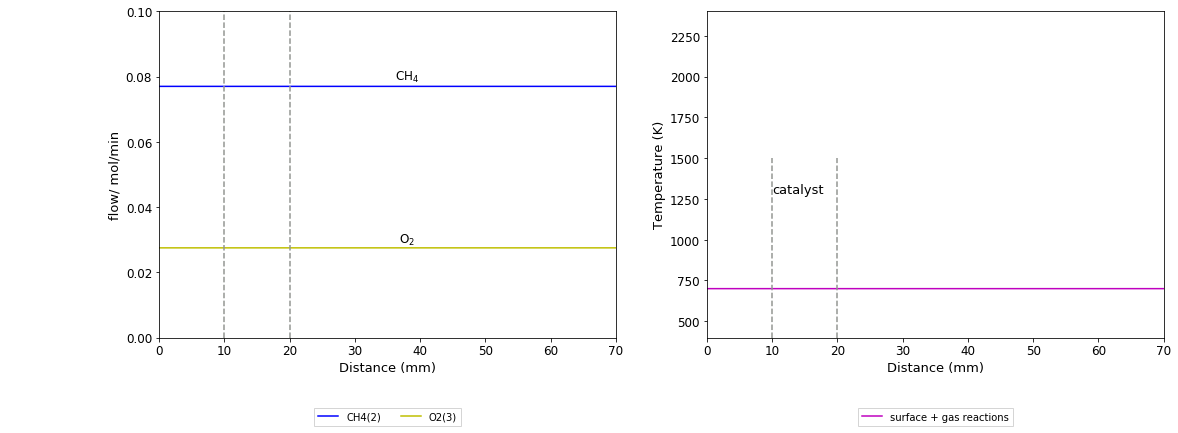

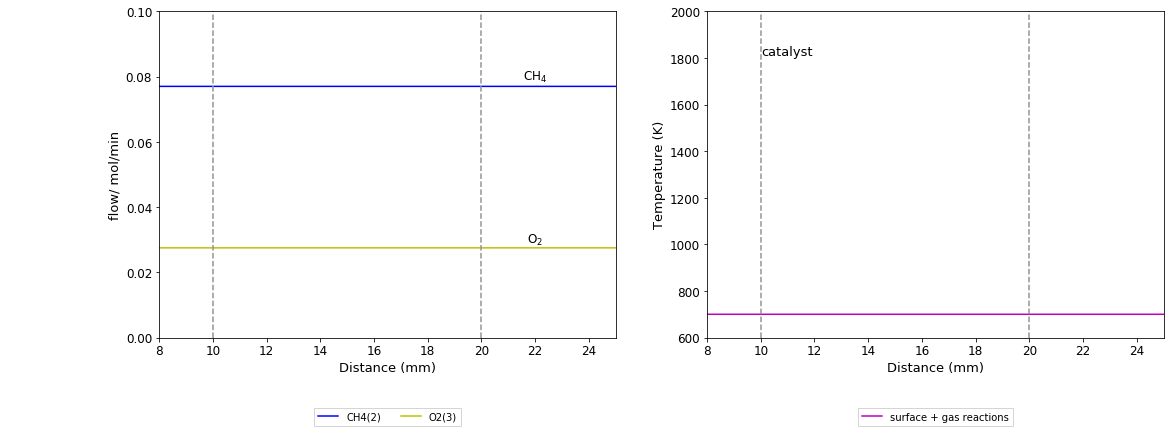

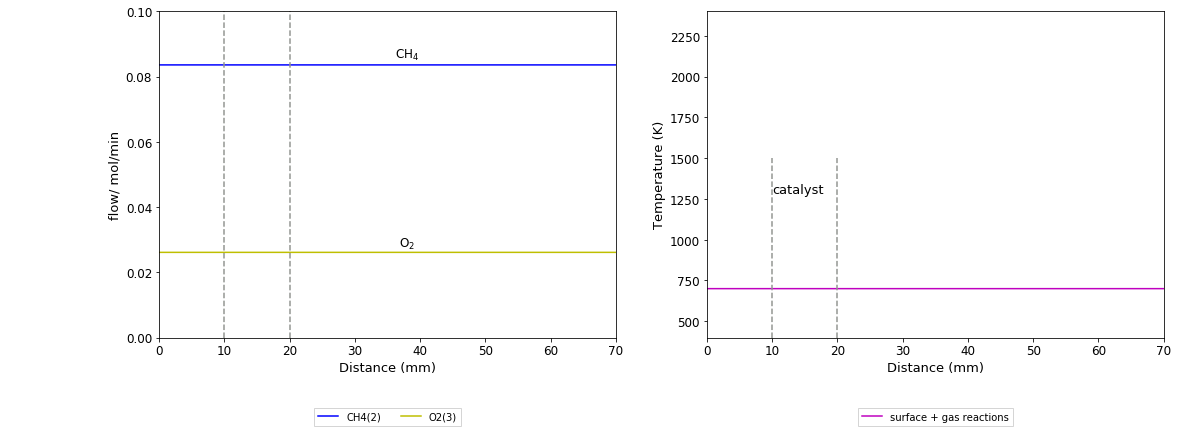

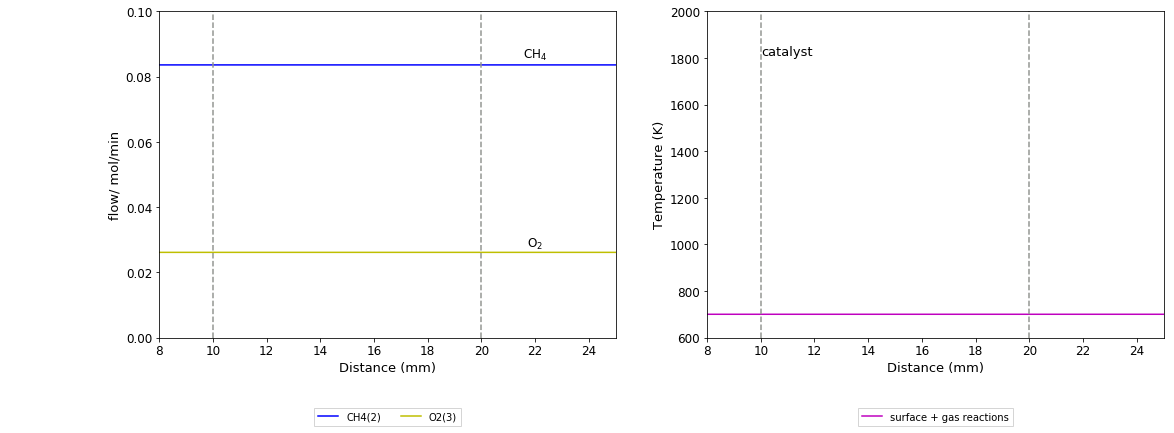

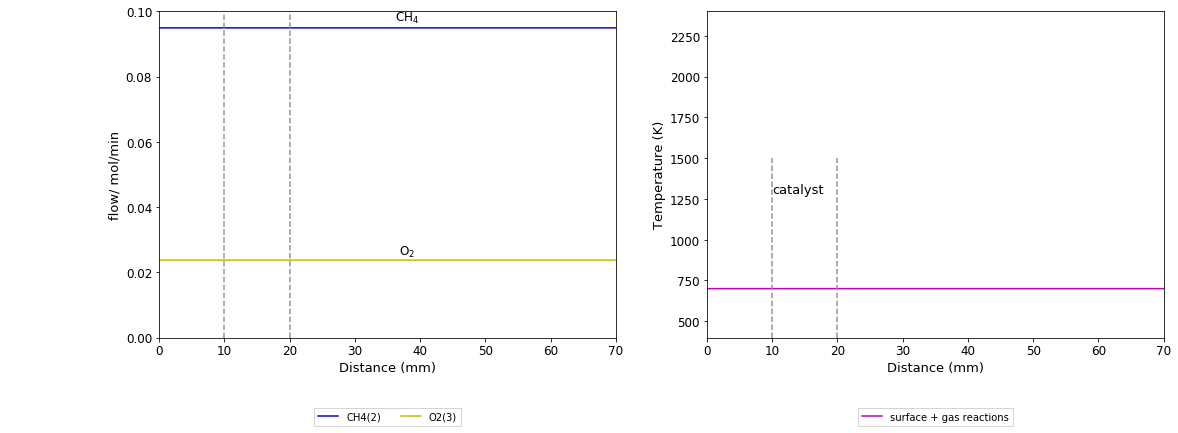

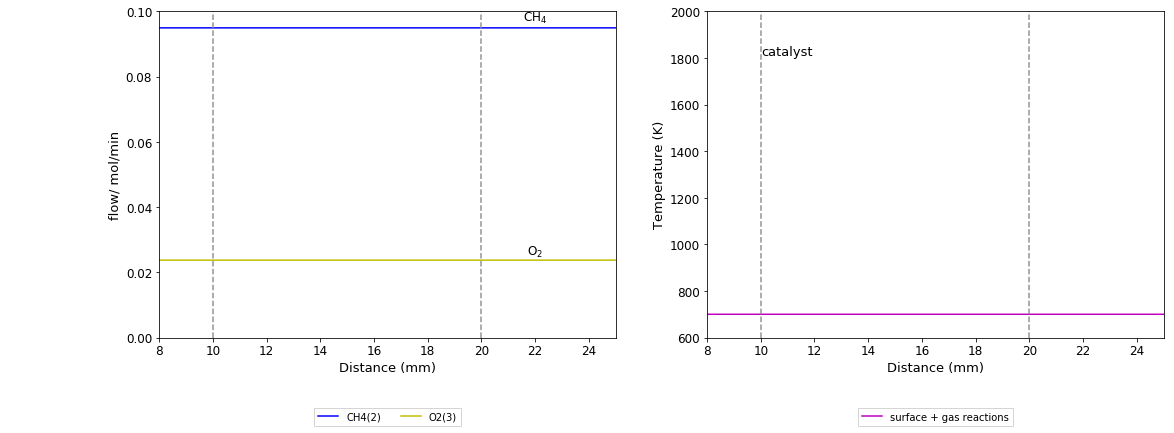

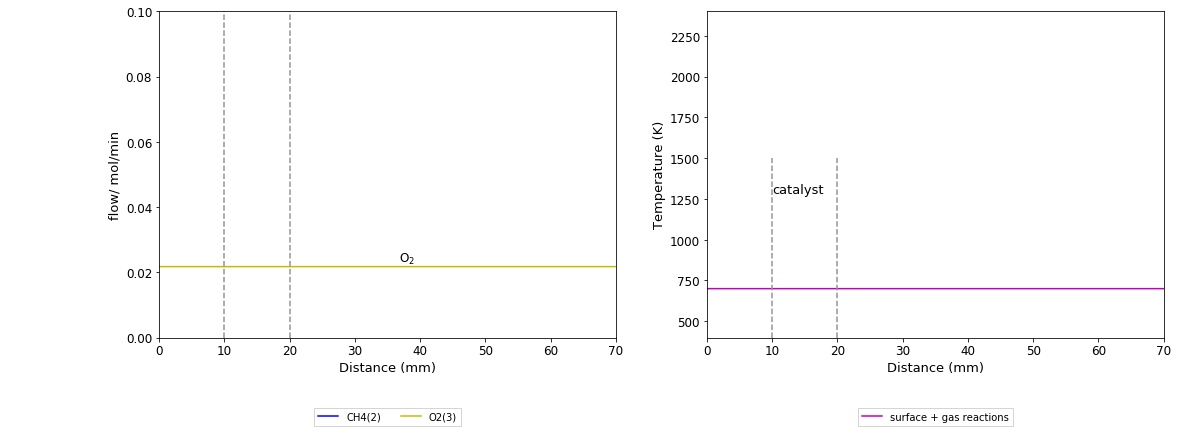

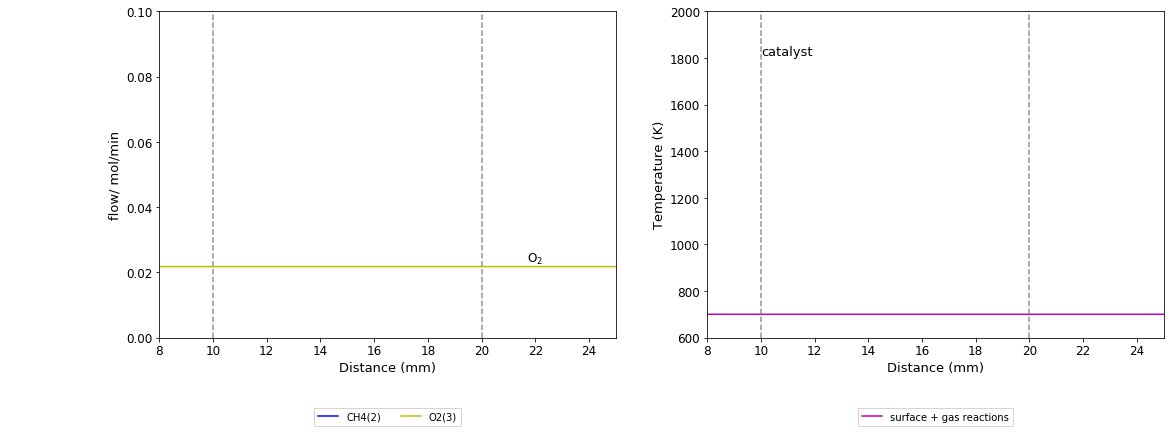

In [7]:
# at different ratios
tot_flow = 0.208 # from Horn 2007, constant inlet flow rate in mol/min, equivalent to 4.7 slpm
ratios = [.6,.7,.8,.9,1.,1.1,1.2,1.3,1.4,1.6,1.8,2.,2.2,2.4,2.6]

data = []
t = t_in # temperature, in K

for r in ratios:
    # get the moles in for a certain ratio
    fo2 = tot_flow/(2.*r+1+79/21)
    fch4 = 2*fo2*r
    far = 79*fo2/21
    
    moles_in = [fch4,fo2,far]
    
    try:
        a = monolithFull(gas,surf,t,moles_in,False)
        plotflow(a)
        plotZoom(a)
        
        gas_out, surf_out, gas_names, surf_names, dist_array, T_array = a
        
        data.append([r,[gas_out,gas_names,dist_array,T_array]])
    except:
        print('Unable to run simulation at a C/O ratio of {:.0f}'.format(r))
        errors.append(r)
        pass

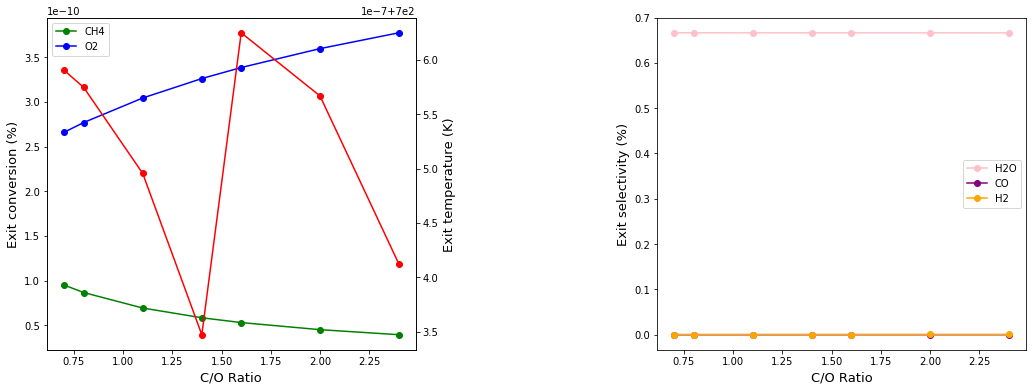

In [8]:
# finding exit conversions
end_temp = []
ch4_conv = []
o2_conv = []
co_sel = []
h2_sel = []
h2o_sel = []
ratios_real = []
for r in data:
#     gas_out,gas_names,dist_array,T_array = r[1]
    for x in range(len(r[1][1])):
        if r[1][1][x]=='CH4(2)':
            ch4_in = r[1][0][0][x]
            ch4_out = r[1][0][-1][x]
            ch4_conv.append((ch4_in-ch4_out)/ch4_in)
        if r[1][1][x]=='O2(3)':
            o2_in = r[1][0][0][x]
            o2_out = r[1][0][-1][x]
            o2_conv.append((o2_in-o2_out)/o2_in)
    ratios_real.append(ch4_in/(2*o2_in))
    end_temp.append(r[1][3][-1])
    
    for x in range(len(r[1][1])):
        if r[1][1][x]=='Ar':
            ar = r[1][0][-1][x]
        if r[1][1][x]=='CO(7)':
            co_out = r[1][0][-1][x]
            co_sel.append(co_out/(1-ch4_out-o2_out-ar))
        if r[1][1][x]=='H2O(5)':
            h2o_out = r[1][0][-1][x]
            h2o_sel.append(h2o_out/(1-ch4_out-o2_out-ar))
        if r[1][1][x]=='H2(6)':
            h2_out = r[1][0][-1][x]
            h2_sel.append(h2_out/(1-ch4_out-o2_out-ar))
        
#     ratios.append(r[0])

# write this metal data to a csv file for later use in the lsr volcano plot

output = []
for x in range(len(ratios_real)):
    output.append([ratios_real[x],ch4_conv[x],o2_conv[x],co_sel[x],h2_sel[x],h2o_sel[x]])

k = (pd.DataFrame.from_dict(data=output, orient='columns'))
k.columns = ['C/O ratio','CH4 Conv','O2 Conv','CO Selec','H2 Selec','H2O Selec']
k.to_csv('dict_conversions_selectivities.csv', header=True)

# def export(rxns_translated,ratio,sens_vals,sens_type=1):
#     answer = dict(zip(rxns_translated, sens_vals))
#     sorted_answer = sorted(answer.items(), key=operator.itemgetter(1), reverse=False)
#     # for x in sorted_answer:
#     #     print '%s %.4f'%(x)
    
#     # write to csv file
#     (pd.DataFrame.from_dict(data=sorted_answer, orient='columns')
#     .to_csv('dict_{}ratio_{}.csv'.format(ratio,sens_type), header=False))


fig, axs = plt.subplots(1,2)
# plot exit conversion and temp
axs[0].plot(ratios_real, ch4_conv,'bo-', label='CH4', color='green')
axs[0].plot(ratios_real, o2_conv, 'bo-',label='O2', color='blue')
ax2 = axs[0].twinx()
ax2.plot(ratios_real, end_temp, 'bo-',label='temp', color = 'red')

# plot exit selectivities
axs[1].plot(ratios_real, h2o_sel, 'bo-',label='H2O', color ='pink')
axs[1].plot(ratios_real, co_sel, 'bo-',label='CO', color ='purple')
axs[1].plot(ratios_real, h2_sel, 'bo-',label='H2', color ='orange')

axs[0].legend()
axs[1].legend()
axs[0].set_ylabel('Exit conversion (%)', fontsize=13);
ax2.set_ylabel('Exit temperature (K)', fontsize=13)
axs[0].set_xlabel('C/O Ratio', fontsize=13);
axs[1].set_ylabel('Exit selectivity (%)', fontsize=13)
axs[1].set_xlabel('C/O Ratio', fontsize=13)
plt.tight_layout()
fig.set_figheight(6)
fig.set_figwidth(16)
fig.savefig('conversion&selectivity.png', bbox_inches='tight')

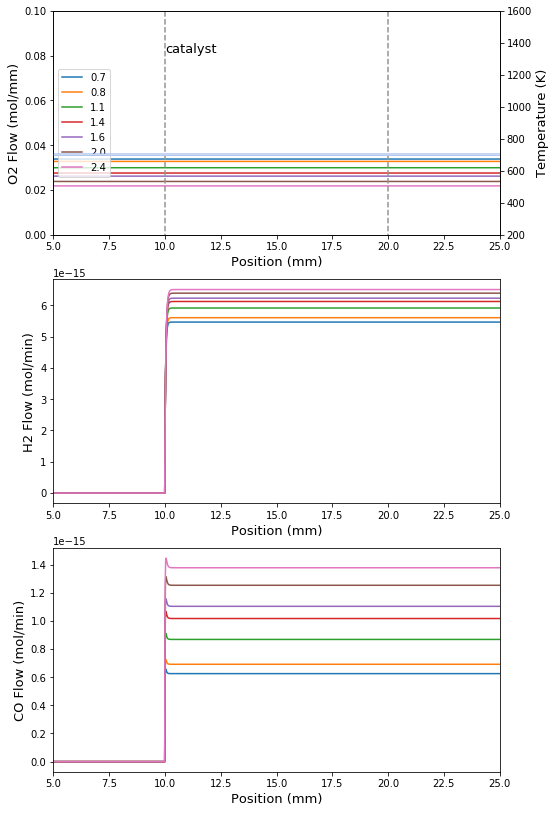

In [9]:
temps = []
o2 = []
co = []
h2 = []
ratios = []
for r in data:
    gas_out,gas_names,dist_array,T_array = r[1]
    for x in range(len(r[1][1])):
        if r[1][1][x]=='O2(3)':
            o2.append(r[1][0][:,x])
        if r[1][1][x]=='CO(7)':
            co.append(r[1][0][:,x])
        if r[1][1][x]=='H2(6)':
            h2.append(r[1][0][:,x])
    dist_array = r[1][2]
            
    temps.append(r[1][3])
    ratios.append(r[0])



fig, axs = plt.subplots(3,1)
sns.set_palette(sns.color_palette("coolwarm",15))
# sns.set_palette(sns.cubehelix_palette(15, start=.5, rot=-1))

# plot exit conversion and temp
for r in range(len(ratios)):
    axs[0].plot(dist_array,o2[r]*.208,label=ratios[r])
    axs[1].plot(dist_array,h2[r]*.208,label=ratios[r])
    axs[2].plot(dist_array,co[r]*.208,label=ratios[r])

ax2 = axs[0].twinx()

# sns.set_palette(sns.color_palette("coolwarm",15))
# sns.set_palette(sns.cubehelix_palette(15, start=.5, rot=-1))

for r in range(len(ratios)):
    ax2.plot(dist_array,temps[r])

axs[0].plot([dist_array[on_catalyst], dist_array[on_catalyst]],[-0.02,0.2], linestyle='--', color='xkcd:grey')
axs[0].plot([dist_array[off_catalyst], dist_array[off_catalyst]],[-0.02,0.2], linestyle='--', color='xkcd:grey')  
axs[0].annotate("catalyst", fontsize=13, xy=(dist_array[on_catalyst], 0.08), va =('bottom'), ha = ('left'))
# axs[1].plot([dist_array[on_catalyst], dist_array[on_catalyst]],[-0.02,.2], linestyle='--', color='xkcd:grey')
# axs[1].plot([dist_array[off_catalyst], dist_array[off_catalyst]],[-.02,0.2], linestyle='--', color='xkcd:grey')
# axs[1].annotate("catalyst", fontsize=13, xy=(dist_array[on_catalyst], .08), va =('bottom'), ha = ('left'))
# axs[2].plot([dist_array[on_catalyst], dist_array[on_catalyst]],[-.02,.2], linestyle='--', color='xkcd:grey')
# axs[2].plot([dist_array[off_catalyst], dist_array[off_catalyst]],[-.02,.2], linestyle='--', color='xkcd:grey')
# axs[2].annotate("catalyst", fontsize=13, xy=(dist_array[on_catalyst], .08), va =('bottom'), ha = ('left'))


axs[0].legend(loc='center left')
# axs[1].legend(loc='center left')
axs[0].set_ylabel('O2 Flow (mol/mm)', fontsize=13);
ax2.set_ylabel('Temperature (K)', fontsize=13)
# ax2.legend(loc='center right')
axs[0].set_xlabel('Position (mm)', fontsize=13);
axs[1].set_ylabel('H2 Flow (mol/min)', fontsize=13)
axs[2].set_ylabel('CO Flow (mol/min)', fontsize=13)
axs[1].set_xlabel('Position (mm)', fontsize=13)
axs[2].set_xlabel('Position (mm)', fontsize=13)
# axs[0].set_title('O2');axs[1].set_title('H2');axs[2].set_title('CO')
ax2.set_ylim(200,1600)
axs[0].set_ylim(0,.1)
axs[0].set_xlim(5,25);axs[1].set_xlim(5,25);axs[2].set_xlim(5,25)
# plt.tight_layout()
fig.set_figheight(14)
fig.set_figwidth(8)
fig.savefig('flows.png', bbox_inches='tight')

In [10]:
##################
## SENSITIVITY
##################

def sensitivity(gas,surf,old_data,temp,dk):
    """
    Function to get sensitivity, but running additional simulations and comparing
    to the original simulation (data) to get a numberical value for sensitivity.
    
    old_data is an array with the original simulation output.
    
    Has multiple ways to calculate sensitivity.  You can use all at once, but was
    written so that the other ways could be commented out.
    """
    rxns = []
    sens1 = []
    sens2 = []
    sens3 = []
    
    gas_out_data,gas_names_data,dist_array_data,T_array_data = old_data
    
    reference = []
    for a in range(len(gas_names_data)):
        reference.append([gas_names_data[a],[gas_out_data[:,a]]])
        
    # getting the ratio
    for x in reference:
        if x[0]=='CH4(2)':
            ch4_in = x[1][0][0]
        if x[0]=='O2(3)':
            o2_in = x[1][0][0]
        if x[0]=='Ar':
            ar_in = x[1][0][0]
    ratio = ch4_in/(2*o2_in)
    moles_in = [ch4_in, o2_in, ar_in]
    
    #####################################
    ## Sensitivity definition 1:
    ##
    ## defining by amt of ch4 conversion
    ## from the beginning of the tube to
    ## the end of the tube
    ## 
    ## negative sensitivity is 'faster' depletion
    #####################################
    for x in reference:
        if x[0]=='CH4(2)':
            ch4_in = x[1][0][0]
            ch4_out = x[1][0][-1]
            reference_ch4_conv = (ch4_in-ch4_out)/(ch4_in)
    
    #####################################
    ## Sensitivity definition 2:
    ##
    ## defining by selectivity of h2 and co
    ## added together
    ##
    ## 
    #####################################
    for x in reference:
        if x[0]=='Ar':
            ar = x[1][0][-1]
        if x[0]=='O2(3)':
            o2_out = x[1][0][-1]
        if x[0]=='CO(7)':
            co_out = x[1][0][-1]
            reference_co_sel = co_out/(1-ch4_out-o2_out-ar)
        if x[0]=='H2(6)':
            h2_out = x[1][0][-1]
            reference_h2_sel = h2_out/(1-ch4_out-o2_out-ar)
    reference_prod_selectivity = reference_co_sel+reference_h2_sel
    
    #####################################
    ## Sensitivity definition 3:
    ##
    ## defining by h2 selectivity at the end
    ## of the tube
    ##
    ##
    #####################################
    reference_h2_sel
    
    #####################################
    ## Sensitivity definition 4:
    ##
    ## defining by co selectivity at the end
    ## of the tube
    ##
    ##
    #####################################
    reference_co_sel
    
    # run the simulations
    for rxn in range(surf.n_reactions):
        c = monolithFull(gas,surf,temp,moles_in,sens=[dk,rxn])
        gas_out, surf_out, gas_names, surf_names, dist_array, T_array = c
        
        # uncomment if sensitivity for surface only reactions are wanted
#         d = monolithNoGas(gas,surf,temp,sens=[dk,rxn])
#         gas2_out, surf2_out, gas2_names, surf2_names, dist2_array, T2_array = d
        
        new_amts = []
        for a in range(len(gas_names)):
            new_amts.append([gas_names[a],[gas_out[:,a]]])
        
        #####################################
        ## Sensitivity definition 1:
        #####################################
        for x in new_amts:
            if x[0]=='CH4(2)':
                new_ch4_out = x[1][0][-1]
                new_ch4_conv = (x[1][0][0]-new_ch4_out)/x[1][0][0]
        Sens1 = (reference_ch4_conv-new_ch4_conv)/(reference_ch4_conv*dk)
        sens1.append(Sens1)
#         print "%d %s %.3F"%(rxn,surf.reaction_equations()[rxn],Sens1)
        
        #####################################
        ## Sensitivity definition 2:
        #####################################
        for x in new_amts:
            if x[0]=='Ar':
                ar = x[1][0][-1]
            if x[0]=='O2(3)':
                new_o2_out = x[1][0][-1]
            if x[0]=='CO(7)':
                new_co_out = x[1][0][-1]
                new_co_sel = new_co_out/(1-new_o2_out-new_ch4_out-ar)
            if x[0]=='H2(6)':
                new_h2_out = x[1][0][-1]
                new_h2_sel = new_h2_out/(1-new_o2_out-new_ch4_out-ar)
        new_prod_selectivity = new_co_sel+new_h2_sel
        Sens2 = (reference_prod_selectivity-new_prod_selectivity)/(reference_prod_selectivity*dk)
        sens2.append(Sens2)
#         print "%d %s %.3F"%(rxn,surf.reaction_equations()[rxn],Sens2)

        #####################################
        ## Sensitivity definition 3:
        #####################################
        Sens3 = (reference_h2_sel-new_h2_sel)/(reference_h2_sel*dk)
        sens3.append(Sens3)
#         print "%d %s %.3F"%(rxn,surf.reaction_equations()[rxn],Sens3)
        
        #####################################
        ## Sensitivity definition 4:
        #####################################
        Sens4 = (reference_co_sel-new_co_sel)/(reference_co_sel*dk)
        sens4.append(Sens4)
#         print "%d %s %.3F"%(rxn,surf.reaction_equations()[rxn],Sens4)
        
        print "%d %s %.3F %.3F %.3F %.3F"%(rxn,surf.reaction_equations()[rxn],Sens1,Sens2,Sens3,Sens4)

        rxns.append(surf.reaction_equations()[rxn])
    return rxns,sens1,sens2,sens3,sens4

In [11]:
reactions = surf.reaction_equations()
print reactions

['CH4(2) + X(1) <=> CH4X(55)', 'O2(3) + 2 X(1) <=> 2 OX(20)', 'H2(6) + 2 X(1) <=> 2 HX(19)', 'CH4(2) + 2 X(1) <=> CH3X(21) + HX(19)', 'CH4(2) + OX(20) + X(1) <=> CH3X(21) + HOX(22)', 'CH4(2) + HOX(22) + X(1) <=> CH3X(21) + H2OX(23)', 'H2O(5) + X(1) <=> H2OX(23)', 'CO2(4) + X(1) <=> CO2X(24)', 'CO(7) + X(1) <=> OCX(25)', 'CX(26) + OX(20) <=> OCX(25) + X(1)', 'OCX(25) + OX(20) <=> CO2X(24) + X(1)', 'CO2X(24) + HX(19) <=> HOX(22) + OCX(25)', 'CH2X(27) + HX(19) <=> CH3X(21) + X(1)', 'CHX(28) + HX(19) <=> CH2X(27) + X(1)', 'CHX(28) + X(1) <=> CX(26) + HX(19)', 'HX(19) + OX(20) <=> HOX(22) + X(1)', 'H2OX(23) + OX(20) <=> 2 HOX(22)', 'CX(26) + H2(6) <=> CH2X(27)', 'HOX(22) + HX(19) <=> H2OX(23) + X(1)']


In [12]:
# Set the value of the perturbation
dk = 1.0e-2

# this takes the longest
sens_by_ratio = []
for r in range(len(data)):
    print data[r][0]
    try:
        reactions,sensitivity1,sensitivity2,sensitivity3,sensitivity4=sensitivity(gas,surf,data[r][1],data[r][0],dk)
        sens_by_ratio.append([data[r][0],sensitivity1,sensitivity2,sensitivity3,sensitivity4])
    except:
        print('Unable to run sensitivity simulation at a C/O ratio of {:.0f}'.format(data[r][0]))
        errors.append(r)
        pass

0.7
Unable to run sensitivity simulation at a C/O ratio of 1
0.8
Unable to run sensitivity simulation at a C/O ratio of 1
1.1
Unable to run sensitivity simulation at a C/O ratio of 1
1.4
Unable to run sensitivity simulation at a C/O ratio of 1
1.6
Unable to run sensitivity simulation at a C/O ratio of 2
2.0
Unable to run sensitivity simulation at a C/O ratio of 2
2.4
Unable to run sensitivity simulation at a C/O ratio of 2


In [13]:
species_dict = rmgpy.data.kinetics.KineticsLibrary().getSpecies('species_dictionary.txt')
keys = species_dict.keys()

# get the first listed smiles string for each molecule
smile = []
for s in species_dict:
    smile.append(species_dict[s].molecule[0])
    if len(species_dict[s].molecule) is not 1:
        print 'There are %d dupllicate smiles for %s:'%(len(species_dict[s].molecule),s)
        for a in range(len(species_dict[s].molecule)):
            print '%s'%(species_dict[s].molecule[a])
            
# translate the molecules from above into just smiles strings
smiles = []
for s in smile:
    smiles.append(s.toSMILES())
    
names = dict(zip(keys,smiles))

rxns_translated = []

# now replace each molecule with smiles
for x in reactions:
    for key, smile in names.iteritems():
        x = re.sub(re.escape(key), smile, x)
    rxns_translated.append(x)

def export(rxns_translated,ratio,sens_vals,sens_type=1):
    answer = dict(zip(rxns_translated, sens_vals))
    sorted_answer = sorted(answer.items(), key=operator.itemgetter(1), reverse=False)
    # for x in sorted_answer:
    #     print '%s %.4f'%(x)
    
    # write to csv file
    (pd.DataFrame.from_dict(data=sorted_answer, orient='columns')
    .to_csv('dict_{}ratio_{}.csv'.format(ratio,sens_type), header=False))

In [14]:
# export everything
for x in sens_by_ratio:
    for s in range(len(x)-1):
        export(rxns_translated,x[0],x[s+1],s+1)

In [15]:
# if there are errors in generating models, print to a separate text file what they are
if len(errors)==0:
    try:
        os.remove('errors.txt')
    except:
        pass
if len(errors) != 0:
    with open('errors.txt','w') as f:
        f.write(str('Error at ratios: '))
        for x in range(len(errors)):
            f.write(str(errors[x]))
            if x != len(errors)-1:
                f.write(str(', '))

# Batch reactor

plt.semilogy(surf.reverse_rates_of_progress,'.')

for i in surf.reverse_rates_of_progress.argsort()[:-5:-1]:
    print i, surf.reaction_equation(i)